## Загрузим нужные библиотеки

In [1]:
!pip install lightgbm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
from sklearn.feature_selection import RFE
import numpy as np
import tensorflow as tf 
from tensorflow import keras
%matplotlib inline

2022-10-24 00:08:32.378925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 00:08:32.378953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


В начале остановимся на наиболее перспективных навыках

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_calls = pd.read_csv("Calls.csv")
df_connection_time = pd.read_csv("ConnectionTime.csv")
df_ed = pd.read_csv("Education.csv")
df_tasks=pd.read_csv('Tasks.csv')
timennetwork=pd.read_csv('TimenNetwork.csv')
workingday=pd.read_csv("WorkingDay.csv")

/tmp/ipykernel_360633/1620961415.py:5: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_connection_time = pd.read_csv("ConnectionTime.csv")
/tmp/ipykernel_360633/1620961415.py:7: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tasks=pd.read_csv('Tasks.csv')


## Рассмотрим датасет по ближе

In [3]:
df_calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [4]:
df_calls['Date'].min()

'2021-01-01 00:00:00,000'

In [5]:
df_calls['Date'].max()

'2021-12-30 00:00:00,000'

In [6]:
df_connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


In [7]:
df_connection_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   dateNum                           230662 non-null  object
 1   maxLogOff                         230662 non-null  object
 2   Нормативное время начала раб.дня  230662 non-null  object
 3   Фактич. время начала раб.дня      230662 non-null  object
 4   Время опоздания                   103101 non-null  object
 5   Признак опоздания                 77520 non-null   object
 6   Вых/Будни                         230662 non-null  object
 7   id                                230662 non-null  object
dtypes: object(8)
memory usage: 14.1+ MB


In [8]:
df_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


In [9]:
df_train.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0


In [10]:
df_test.head(3)

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0


Узнаем размерность наборов

In [11]:
print("df_train", df_train.shape)
print("df_calls", df_calls.shape)
print("df_connection_time", df_connection_time.shape)
print("df_ed", df_ed.shape)
print("df_test", df_test.shape)

df_train (550, 2)
df_calls (407867, 6)
df_connection_time (230662, 8)
df_ed (5609, 4)
df_test (262, 2)


### Видоизмение данных

Обьединим два набора с данными

In [12]:
df_train = pd.merge(df_train, df_ed , on="id", how='left').drop_duplicates(subset="id")

df_train.head(3)

,id,type,Табельный номер руководителя,Вид образования,Специальность
0,ОРГ1-02050,2,NaN,Неполное высшее образование,Технологические машины и оборудование
2,ОРГ1-02783,2,ОРГ1-01974,Высшее образование,Автоматизация технологических процессов и прои...
3,ОРГ2-06173,0,ОРГ2-01170,Высшее образование,Управление качеством


In [13]:
df_train = df_train.drop(["Табельный номер руководителя", "Специальность"],axis = 1)

df_train["Вид образования"].value_counts()

Высшее образование                                297
Среднее профессиональное образование               64
Высшее образование - бакалавриат                   59
Высшее образование - специалитет, магистратура     30
Начальное профессиональное образование              7
Повышение квалификации                              7
Неполное высшее образование                         5
Среднее общее образование                           3
Среднее (полное) общее образование                  2
Переподготовка                                      2
Профессиональное обучение                           1
Name: Вид образования, dtype: int64

In [14]:
df_train["Вид образования"] = df_train["Вид образования"].astype('category')
df_train["Вид образования"] = df_train["Вид образования"].cat.codes

df_train["Вид образования"].value_counts()

 0     297
-1      73
 10     64
 1      59
 2      30
 3       7
 6       7
 4       5
 9       3
 8       2
 5       2
 7       1
Name: Вид образования, dtype: int64

Оставим только столбец - опоздания сотрудников

In [15]:
df_connection_time_res = df_connection_time[["id","Признак опоздания"]]
df_connection_time_res = df_connection_time_res[df_connection_time_res["Признак опоздания"].notna()]

df_connection_time_res.head()

,id,Признак опоздания
127561,ОРГ1-01589,Опоздание
127562,ОРГ1-01589,Опоздание
127563,ОРГ1-01589,Опоздание
127564,ОРГ1-01589,Опоздание
127565,ОРГ1-01589,Опоздание


In [16]:
df_connection_time_res = df_connection_time_res.groupby("id").count()
df_connection_time_res = df_connection_time_res.rename(columns={"Признак опоздания": "Число опозданий"})

df_connection_time_res.head(3)

,Число опозданий
id,
ОРГ1-00004,275
ОРГ1-00028,35
ОРГ1-00030,57


In [17]:
df_train = pd.merge(df_train, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

df_train.head(3)

,id,type,Вид образования,Число опозданий
0,ОРГ1-02050,2,4,5.0
1,ОРГ1-02783,2,0,7.0
2,ОРГ2-06173,0,0,22.0


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               550 non-null    object 
 1   type             550 non-null    int64  
 2   Вид образования  550 non-null    int8   
 3   Число опозданий  491 non-null    float64
dtypes: float64(1), int64(1), int8(1), object(1)
memory usage: 17.7+ KB


## Добавим суммарное время звонков!



In [19]:
def str_to_float(str):
    if type(str)==float:
        return str
    str=str.replace(',','')
    return float(str)

df_calls['CallTime']=df_calls['CallTime'].map(str_to_float)
CallTime=pd.DataFrame(df_calls.groupby('id')['CallTime'].sum()).reset_index()
df_train = pd.merge(df_train, CallTime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime
0,ОРГ1-02050,2,4,5.0,4.810983e+18
1,ОРГ1-02783,2,0,7.0,1.350599e+19
2,ОРГ2-06173,0,0,22.0,NaN
3,ОРГ2-05359,2,10,6.0,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17
...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19
547,ОРГ1-02862,2,-1,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19


In [20]:
df_calls['NumberOfCalls'].value_counts()

1      140167
2       60780
3       33555
4       27493
5       19761
        ...  
107         1
105         1
114         1
98          1
95          1
Name: NumberOfCalls, Length: 102, dtype: int64

## Добавим колличество звонков в будни и выходные

In [21]:
NumberOfCalls=pd.DataFrame(df_calls.groupby('id')['NumberOfCalls'].sum()).reset_index()
df_calls= df_calls.rename(columns={'Вид учета времени': 'statusworkfre'})

NumberOfCallsW=pd.DataFrame(df_calls.query("statusworkfre=='Будни'").groupby('id')['NumberOfCalls'].sum()).reset_index()
NumberOfCallsNW=pd.DataFrame(df_calls.query("statusworkfre=='Выходные дни'").groupby('id')['NumberOfCalls'].sum()).reset_index()
df_train = pd.merge(df_train, NumberOfCalls , on="id", how='left')
df_train = pd.merge(df_train, NumberOfCallsW , on="id", how='left')
df_train = pd.merge(df_train, NumberOfCallsNW , on="id", how='left')
df_train = df_train.rename(columns={'NumberOfCalls_x': 'NumberOfCalls_worck','NumberOfCalls_y': 'NumberOfCalls_free','NumberOfCalls': 'NumberOfCallsfreesum'})
df_train


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN
...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0


## Добавим колличество входящих и исходящих.

In [22]:
NumberToUser=pd.DataFrame(df_calls.query("InOut=='ToUser'").groupby('id')['NumberOfCalls'].sum()).reset_index()
NumberFromUser=pd.DataFrame(df_calls.query("InOut=='FromUser'").groupby('id')['NumberOfCalls'].sum()).reset_index() 
df_train = pd.merge(df_train, NumberToUser , on="id", how='left')
df_train = pd.merge(df_train, NumberFromUser , on="id", how='left')

## Добавим суммарное время опазданий

In [23]:
df_connection_time['Время опоздания']=df_connection_time['Время опоздания'].map(str_to_float)
falout=pd.DataFrame(df_connection_time.groupby('id')['Время опоздания'].sum()).reset_index() 
df_train = pd.merge(df_train, falout , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17
...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17


## Добавим дельту прихода на работу

In [24]:
df_connection_time['Нормативное время начала раб.дня']=pd.to_datetime(df_connection_time['Нормативное время начала раб.дня'])
df_connection_time['Фактич. время начала раб.дня']=pd.to_datetime(df_connection_time['Фактич. время начала раб.дня'])
df_connection_time['filtime']=df_connection_time['Нормативное время начала раб.дня']-df_connection_time['Фактич. время начала раб.дня']
filtime=pd.DataFrame(df_connection_time.groupby('id')['filtime'].mean().dt.total_seconds()).reset_index()
df_train = pd.merge(df_train, filtime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892
...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964


In [25]:
# Сброс ограничений на количество выводимых рядов
#pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
#pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
#pd.set_option('display.max_colwidth', None)

## Добавим Профессию

In [26]:
prof=pd.DataFrame(df_ed['Специальность'].value_counts()).reset_index()
profhed=prof.head(457)
profhed['profcod']=profhed.index
proftail=prof.tail(623)
proftail['profcod']=999
profhed=profhed.append(proftail)
profhed= profhed.rename(columns={'index': 'specialisation'})
uniq = profhed['specialisation'].values
fifa = profhed['profcod'].values
uniq_and_fifa = dict(zip(uniq, fifa))
uniq_and_fifa
df_ed['Специальность']=df_ed['Специальность'].map(uniq_and_fifa)
professionstart=df_ed[['id','Специальность']].groupby('id')['Специальность'].min()
professionend=df_ed[['id','Специальность']].groupby('id')['Специальность'].max()
df_train = pd.merge(df_train, professionstart , on="id", how='left')
df_train = pd.merge(df_train, professionend , on="id", how='left')
df_train

/tmp/ipykernel_360633/2507229956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profhed['profcod']=profhed.index
/tmp/ipykernel_360633/2507229956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proftail['profcod']=999
/tmp/ipykernel_360633/2507229956.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  profhed=profhed.append(proftail)


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096,21.0,21.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628,16.0,16.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839,116.0,116.0
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912,999.0,999.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892,365.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864,24.0,24.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964,136.0,160.0


## Добавим rколичество  руководителей

In [27]:
df_ed

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,6.0
1,NaN,ОРГ1-03220,Среднее профессиональное образование,135.0
2,NaN,ОРГ1-03008,Высшее образование,6.0
3,NaN,ОРГ1-00922,Высшее образование - бакалавриат,999.0
4,NaN,ОРГ1-00922,Высшее образование,35.0
...,...,...,...,...
5604,ОРГ2-09100,ОРГ2-08601,Начальное профессиональное образование,55.0
5605,ОРГ2-09100,ОРГ2-08622,Начальное профессиональное образование,NaN
5606,ОРГ2-09100,ОРГ2-04773,Среднее профессиональное образование,275.0
5607,ОРГ2-09100,ОРГ2-05048,"Высшее образование - специалитет, магистратура",257.0


In [28]:
boss=df_ed.groupby('id')['Табельный номер руководителя'].count()

In [29]:
df_train = pd.merge(df_train, boss , on="id", how='left')

# Добавим колличество завершенных заданий

In [30]:
df_tasks['Вид документа'].value_counts()

Служебная записка                              219740
Входящий                                        85972
Исходящий                                       76326
Приказ                                          43382
Внутренний документ                             27526
Договор                                         21082
Дополнительное соглашение                       20128
Акт                                             17999
Распоряжение                                     5898
Файл                                             5704
Протокол                                         3519
Исходящий РМЗ                                    2748
Внутренний документ для БП синхронизация 1С      2201
Запрос на внесение изменений                      665
Отчет по ВА                                       253
Name: Вид документа, dtype: int64

In [31]:
df_tasks

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
...,...,...,...,...,...,...,...,...,...,...,...
536655,Без нарушения срока,NaN,0,без нарушения срока,9FE7B014-3015-4855-BD08-D3C5260FB122,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536656,Без нарушения срока,NaN,0,без нарушения срока,B4A7AE02-2D7E-4D56-A337-0F14C27A85CC,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536657,Без нарушения срока,NaN,0,без нарушения срока,698F3F66-37BA-4042-BDE9-5F8C8BEA7FA6,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536658,Без нарушения срока,NaN,0,без нарушения срока,A7D0F2FA-9C2A-4F4D-A990-ABE463A5F0D5,Служебная записка,"2021-10-30 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838


In [32]:
df_tasks['Статус по просрочке'].value_counts()

Без нарушения срока    454148
С нарушением срока      82512
Name: Статус по просрочке, dtype: int64

In [33]:
df_tasks = df_tasks.rename(columns={'Состояние задания': 'status_mission_count','Статус по просрочке':'статус_просрочек'})
status_mission_count=pd.DataFrame(df_tasks.query("status_mission_count=='Завершено'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'завершено'})
df_train = pd.merge(df_train,status_mission_count, on="id", how='left')

# Добавим колличество заданий в работе.

In [34]:
status_mission_count_in=pd.DataFrame(df_tasks.query("status_mission_count=='В работе'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'вработе'})
df_train = pd.merge(df_train,status_mission_count_in, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y,Табельный номер руководителя,завершено,вработе
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096,21.0,21.0,0.0,1.0,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628,16.0,16.0,1.0,306.0,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839,116.0,116.0,1.0,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912,999.0,999.0,1.0,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892,365.0,365.0,0.0,155.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864,24.0,24.0,0.0,102.0,3.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964,136.0,160.0,0.0,33.0,NaN


# Добавим колличество заданий Не начато

In [35]:
status_mission_count_nn=pd.DataFrame(df_tasks.query("status_mission_count=='Не начато'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'неначато'})
df_train = pd.merge(df_train,status_mission_count_nn, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y,Табельный номер руководителя,завершено,вработе,неначато
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096,21.0,21.0,0.0,1.0,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628,16.0,16.0,1.0,306.0,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839,116.0,116.0,1.0,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912,999.0,999.0,1.0,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892,365.0,365.0,0.0,155.0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,NaN,16.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864,24.0,24.0,0.0,102.0,3.0,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964,136.0,160.0,0.0,33.0,NaN,NaN


# Добавим колличество заданий делегировано

In [36]:
status_mission_count_d=pd.DataFrame(df_tasks.query("status_mission_count=='Делегировано'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'делегировано'})
df_train = pd.merge(df_train,status_mission_count_d, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y,Табельный номер руководителя,завершено,вработе,неначато,делегировано
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096,21.0,21.0,0.0,1.0,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628,16.0,16.0,1.0,306.0,NaN,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839,116.0,116.0,1.0,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912,999.0,999.0,1.0,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892,365.0,365.0,0.0,155.0,NaN,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,NaN,16.0,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864,24.0,24.0,0.0,102.0,3.0,NaN,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964,136.0,160.0,0.0,33.0,NaN,NaN,NaN


# Добавим колличество заданий На приёмке

In [37]:
status_mission_count_p=pd.DataFrame(df_tasks.query("status_mission_count=='На приёмке'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'наприемке'})
df_train = pd.merge(df_train,status_mission_count_p, on="id", how='left')
df_train


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y,Табельный номер руководителя,завершено,вработе,неначато,делегировано,наприемке
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,2.361381e+17,276.332096,21.0,21.0,0.0,1.0,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,2.532397e+17,-695.247628,16.0,16.0,1.0,306.0,NaN,NaN,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1.200253e+18,-608.828839,116.0,116.0,1.0,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.657396e+17,2186.244912,999.0,999.0,1.0,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,9.288578e+17,-14381.555892,365.0,365.0,0.0,155.0,NaN,4.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,NaN,16.0,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,2.432262e+18,-7348.409864,24.0,24.0,0.0,102.0,3.0,NaN,NaN,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,5.449973e+17,-58.303964,136.0,160.0,0.0,33.0,NaN,NaN,NaN,NaN


# Добавим колличество заданий Отложено

In [38]:
status_mission_count_o=pd.DataFrame(df_tasks.query("status_mission_count=='Отложено'").groupby('id')['status_mission_count'].count()).reset_index().rename(columns={'status_mission_count': 'Отложено'})
df_train = pd.merge(df_train,status_mission_count_o, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,filtime,Специальность_x,Специальность_y,Табельный номер руководителя,завершено,вработе,неначато,делегировано,наприемке,Отложено
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,276.332096,21.0,21.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,-695.247628,16.0,16.0,1.0,306.0,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-608.828839,116.0,116.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2186.244912,999.0,999.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,-14381.555892,365.0,365.0,0.0,155.0,NaN,4.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,123.0,NaN,16.0,NaN,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,-7348.409864,24.0,24.0,0.0,102.0,3.0,NaN,NaN,NaN,NaN
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,-58.303964,136.0,160.0,0.0,33.0,NaN,NaN,NaN,NaN,NaN


## Добавим сумму просрочки дней!

In [39]:
day_ful_mission=pd.DataFrame(df_tasks.groupby('id')['Просрочено, дней'].sum()).reset_index().rename(columns={'Просрочено, дней': 'просрочено всего'})
df_train = pd.merge(df_train,day_ful_mission, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,Специальность_x,Специальность_y,Табельный номер руководителя,завершено,вработе,неначато,делегировано,наприемке,Отложено,просрочено всего
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,21.0,21.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,16.0,16.0,1.0,306.0,NaN,NaN,NaN,NaN,NaN,861.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,116.0,116.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,999.0,999.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,365.0,365.0,0.0,155.0,NaN,4.0,1.0,NaN,NaN,1976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,123.0,NaN,16.0,NaN,NaN,NaN,3656.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,24.0,24.0,0.0,102.0,3.0,NaN,NaN,NaN,NaN,12199.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,136.0,160.0,0.0,33.0,NaN,NaN,NaN,NaN,NaN,53.0


# Добавим статус по просрочке с нарушением без науршения и их отношение.

In [40]:
fail_count_b=pd.DataFrame(df_tasks.query('статус_просрочек=="Без нарушения срока"').groupby('id')['статус_просрочек'].count())
fail_count_p=pd.DataFrame(df_tasks.query('статус_просрочек=="С нарушением срока"').groupby('id')['статус_просрочек'].count()).rename(columns={'статус_просрочек': 'просрочено'})
df_train = pd.merge(df_train,fail_count_b, on="id", how='left')
df_train = pd.merge(df_train,fail_count_p, on="id", how='left')
df_train['bp']=df_train['статус_просрочек']/df_train['просрочено']

# Добавим общее время активности в сети

In [41]:
timennetwork_time=pd.DataFrame(timennetwork.groupby('id')['monitor_Time'].sum())
df_train = pd.merge(df_train,timennetwork_time, on="id", how='left')

# Добавим среднее время простоя монитора  

In [42]:
workingday['monitorTime_mean']=workingday['monitorTime']-workingday['activeTime']
monitor_stop=pd.DataFrame(workingday.groupby('id')['monitorTime_mean'].mean())
df_train = pd.merge(df_train,monitor_stop, on="id", how='left')

# Добавим счетчик начал рабочего дня

In [43]:
df_connection_time=df_connection_time.rename(columns={'Нормативное время начала раб.дня': 'начало_дня'})
start_day=pd.DataFrame(df_connection_time.groupby('id')['начало_дня'].count())
df_train = pd.merge(df_train,start_day, on="id", how='left')

In [44]:
df_train


,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,делегировано,наприемке,Отложено,просрочено всего,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,2762376.0,8073.693333,114.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,NaN,861.0,256.0,50.0,5.120000,3667950.0,5404.023349,129.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2141948.0,596.958298,125.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,1.0,NaN,NaN,1976.0,141.0,19.0,7.421053,80139.0,35.529101,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3656.0,93.0,46.0,2.021739,2369664.0,720.741639,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,NaN,12199.0,20.0,85.0,0.235294,1936264.0,6290.453890,162.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1642839.0,1102.914224,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,NaN,53.0,25.0,8.0,3.125000,971065.0,15069.358263,137.0


# Добавим колличество уникальных профессий

In [45]:

prof_countis=pd.DataFrame(df_ed.groupby('id')['Специальность'].nunique())
df_train = pd.merge(df_train,prof_countis, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,наприемке,Отложено,просрочено всего,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,NaN,0.0,1.0,NaN,NaN,2762376.0,8073.693333,114.0,1.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,NaN,861.0,256.0,50.0,5.120000,3667950.0,5404.023349,129.0,1.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,1.0
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2141948.0,596.958298,125.0,1.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,NaN,1976.0,141.0,19.0,7.421053,80139.0,35.529101,37.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3656.0,93.0,46.0,2.021739,2369664.0,720.741639,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,NaN,12199.0,20.0,85.0,0.235294,1936264.0,6290.453890,162.0,1.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1642839.0,1102.914224,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,NaN,53.0,25.0,8.0,3.125000,971065.0,15069.358263,137.0,2.0


# Добавим оборотные виды документов.

In [46]:
df_tasks
documents=pd.DataFrame(df_tasks.groupby('id')['Вид документа'].nunique())
df_train = pd.merge(df_train,documents, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,Отложено,просрочено всего,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,NaN,0.0,1.0,NaN,NaN,2762376.0,8073.693333,114.0,1.0,1.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,NaN,861.0,256.0,50.0,5.120000,3667950.0,5404.023349,129.0,1.0,5.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,1.0,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2141948.0,596.958298,125.0,1.0,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,NaN,1976.0,141.0,19.0,7.421053,80139.0,35.529101,37.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3656.0,93.0,46.0,2.021739,2369664.0,720.741639,NaN,NaN,7.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,NaN,12199.0,20.0,85.0,0.235294,1936264.0,6290.453890,162.0,1.0,5.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1642839.0,1102.914224,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,NaN,53.0,25.0,8.0,3.125000,971065.0,15069.358263,137.0,2.0,5.0


# Добавим месяцы звонков

In [47]:
df_calls['monday']=pd.to_datetime(df_calls["Date"]).dt.month
monday_calls=pd.DataFrame(df_calls.groupby('id')['monday'].nunique())
df_train = pd.merge(df_train,monday_calls, on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,просрочено всего,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа,monday
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,0.0,1.0,NaN,NaN,2762376.0,8073.693333,114.0,1.0,1.0,10.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,861.0,256.0,50.0,5.120000,3667950.0,5404.023349,129.0,1.0,5.0,10.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,168.0,1.0,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2141948.0,596.958298,125.0,1.0,NaN,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,1976.0,141.0,19.0,7.421053,80139.0,35.529101,37.0,1.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3656.0,93.0,46.0,2.021739,2369664.0,720.741639,NaN,NaN,7.0,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,12199.0,20.0,85.0,0.235294,1936264.0,6290.453890,162.0,1.0,5.0,12.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1642839.0,1102.914224,NaN,NaN,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,53.0,25.0,8.0,3.125000,971065.0,15069.358263,137.0,2.0,5.0,12.0


# Добавим месяцы в сети

In [48]:
timennetwork['mondayW']=pd.to_datetime(timennetwork['startTime']).dt.month
monday_worck=pd.DataFrame(timennetwork.groupby('id')['mondayW'].nunique())     
df_train = pd.merge(df_train,monday_worck, on="id", how='left')
df_train                                      

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа,monday,mondayW
0,ОРГ1-02050,2,4,5.0,4.810983e+18,546.0,546.0,NaN,176.0,370.0,...,1.0,NaN,NaN,2762376.0,8073.693333,114.0,1.0,1.0,10.0,7.0
1,ОРГ1-02783,2,0,7.0,1.350599e+19,1902.0,1902.0,NaN,657.0,1245.0,...,256.0,50.0,5.120000,3667950.0,5404.023349,129.0,1.0,5.0,10.0,7.0
2,ОРГ2-06173,0,0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,168.0,1.0,NaN,NaN,NaN
3,ОРГ2-05359,2,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2141948.0,596.958298,125.0,1.0,NaN,NaN,7.0
4,ОРГ1-00803,2,0,35.0,1.388889e+17,7.0,7.0,NaN,1.0,6.0,...,141.0,19.0,7.421053,80139.0,35.529101,37.0,1.0,5.0,3.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.0,46.0,2.021739,2369664.0,720.741639,NaN,NaN,7.0,NaN,7.0
546,ОРГ1-02383,2,0,54.0,2.259805e+19,4570.0,4234.0,336.0,1692.0,2878.0,...,20.0,85.0,0.235294,1936264.0,6290.453890,162.0,1.0,5.0,12.0,7.0
547,ОРГ1-02862,2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1642839.0,1102.914224,NaN,NaN,NaN,NaN,5.0
548,ОРГ1-00471,2,-1,12.0,1.749719e+19,3917.0,3638.0,279.0,1088.0,2829.0,...,25.0,8.0,3.125000,971065.0,15069.358263,137.0,2.0,5.0,12.0,7.0


## Заменим пропуски на нули

In [49]:
df_train = df_train.fillna(0)

In [50]:
#df_train.append(df_train)


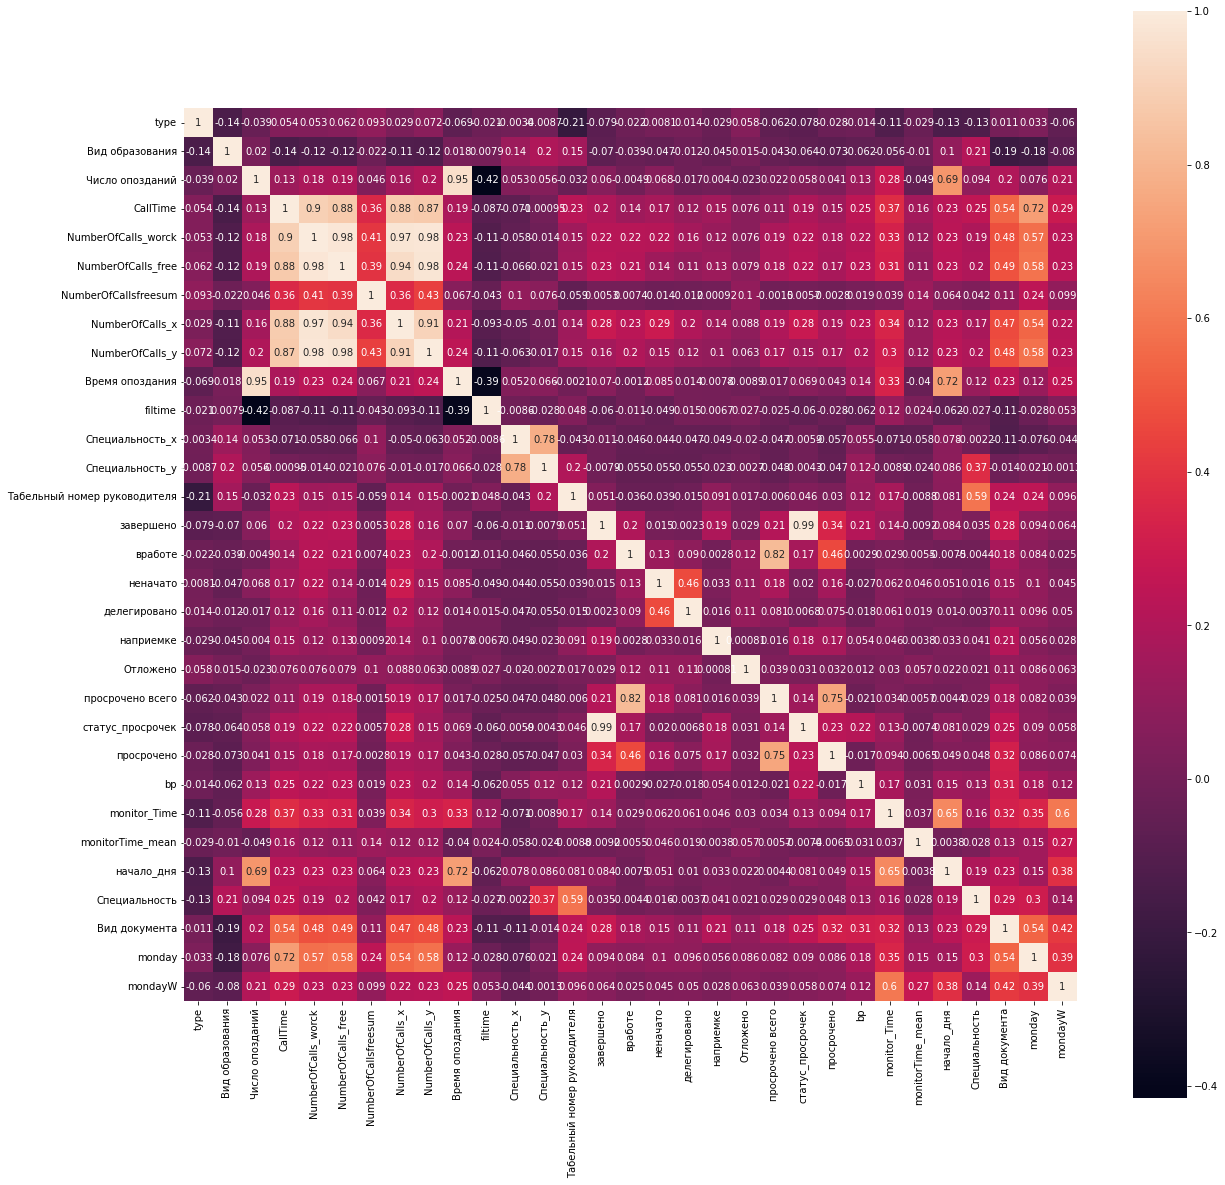

In [51]:
plt.rcParams['figure.figsize']=(20,20)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

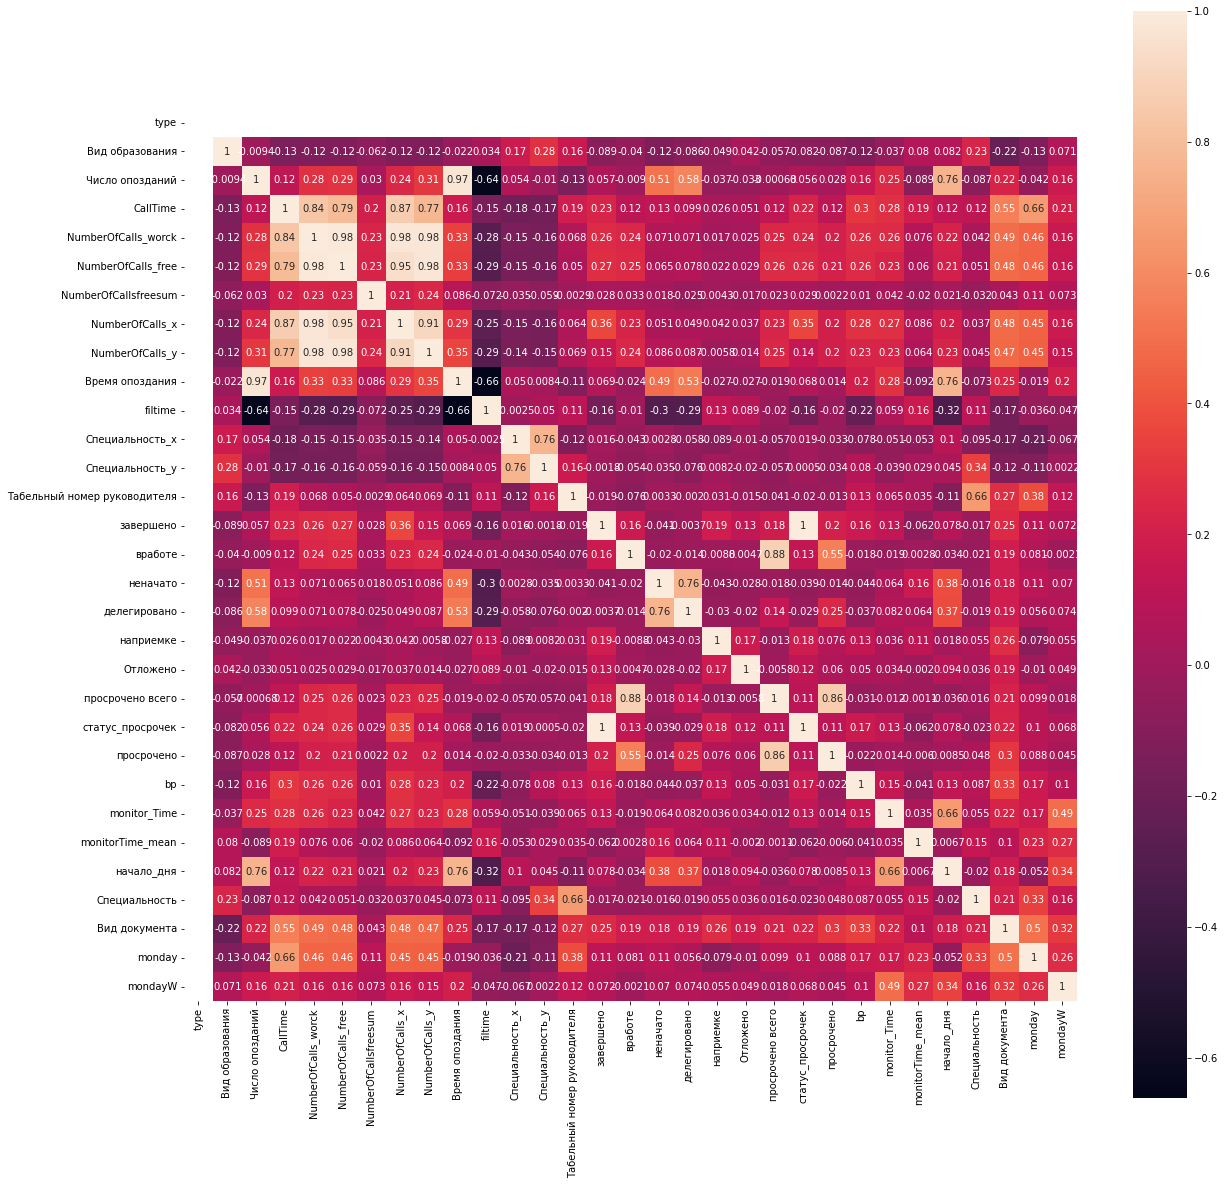

In [52]:
plt.rcParams['figure.figsize']=(20,20)

corr = df_train.query('type==0').corr()
g = sns.heatmap(corr, square = True, annot=True)

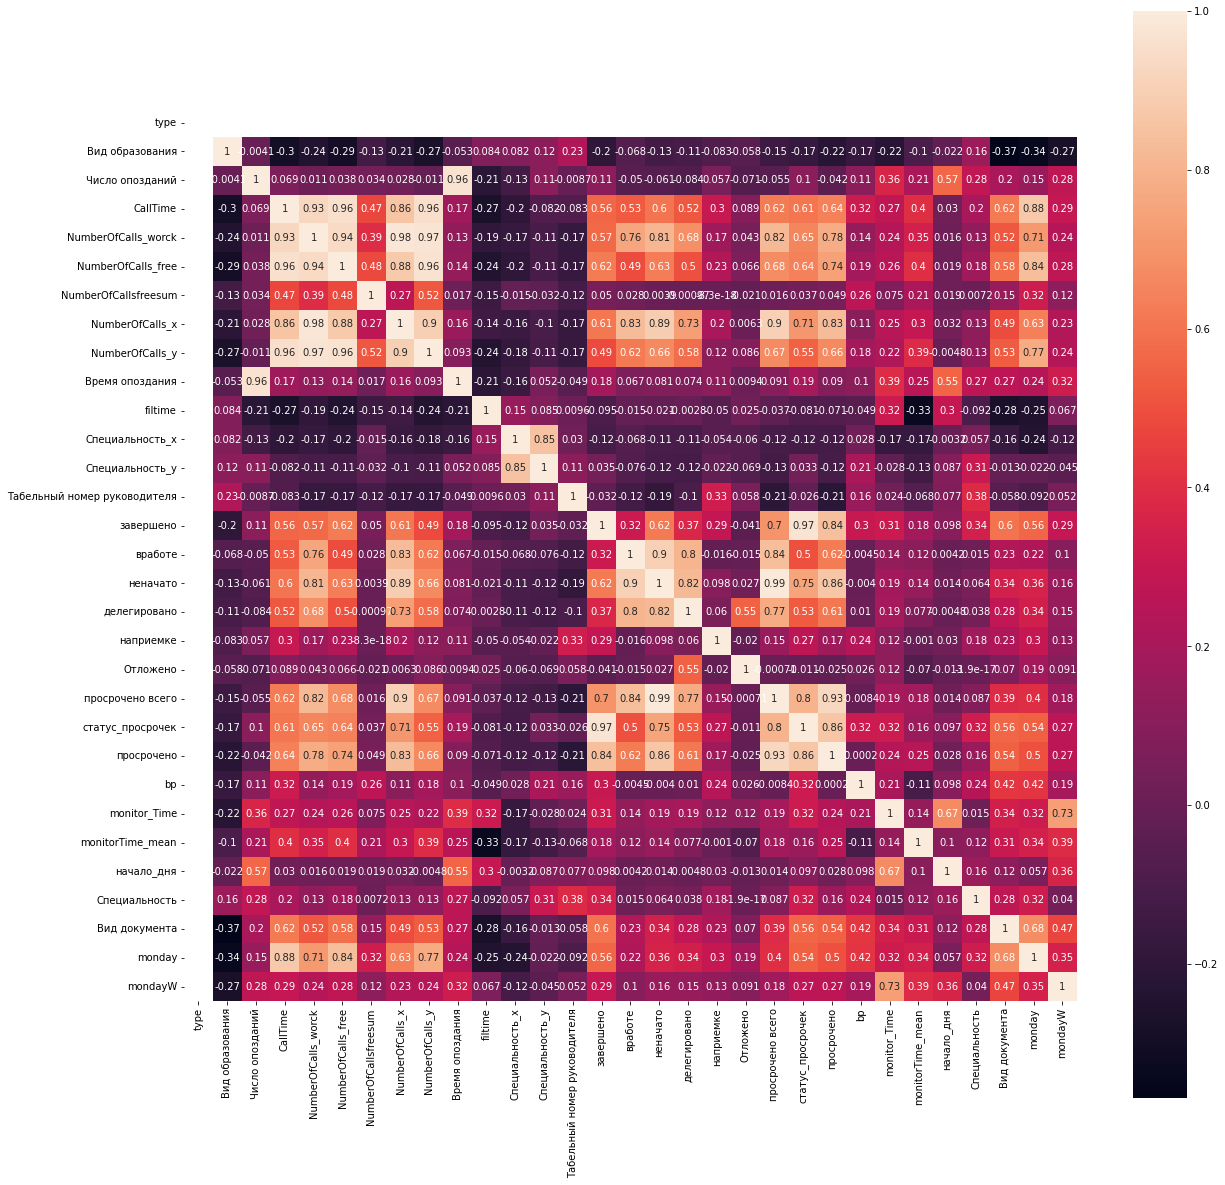

In [53]:
plt.rcParams['figure.figsize']=(20,20)

corr = df_train.query('type==1').corr()
g = sns.heatmap(corr, square = True, annot=True)

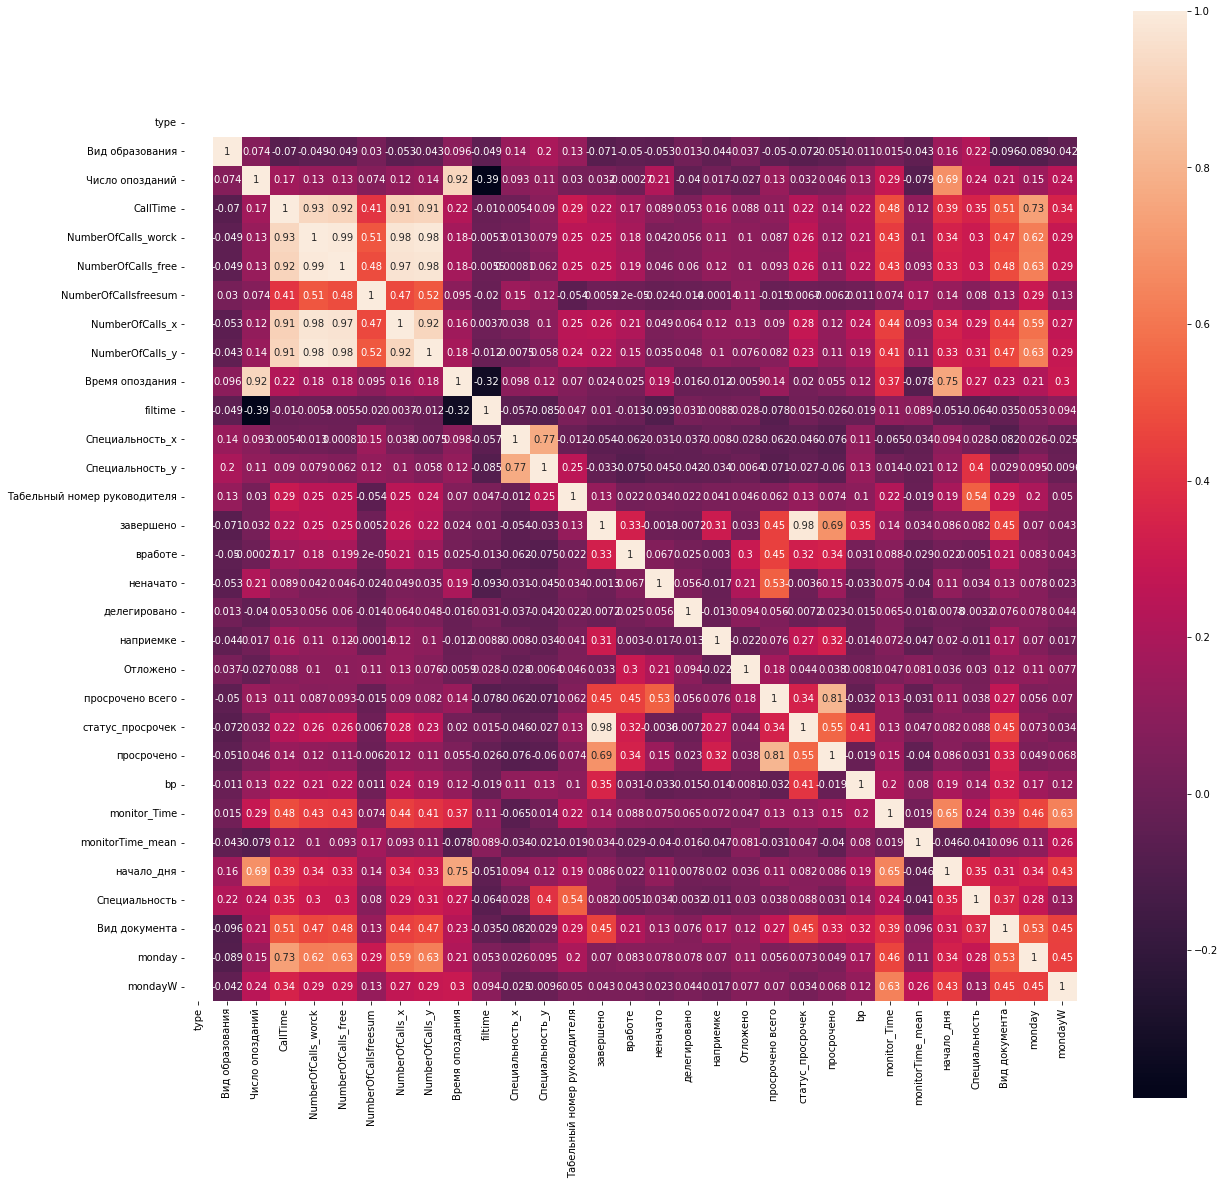

In [54]:
plt.rcParams['figure.figsize']=(20,20)

corr = df_train.query('type==2').corr()
g = sns.heatmap(corr, square = True, annot=True)

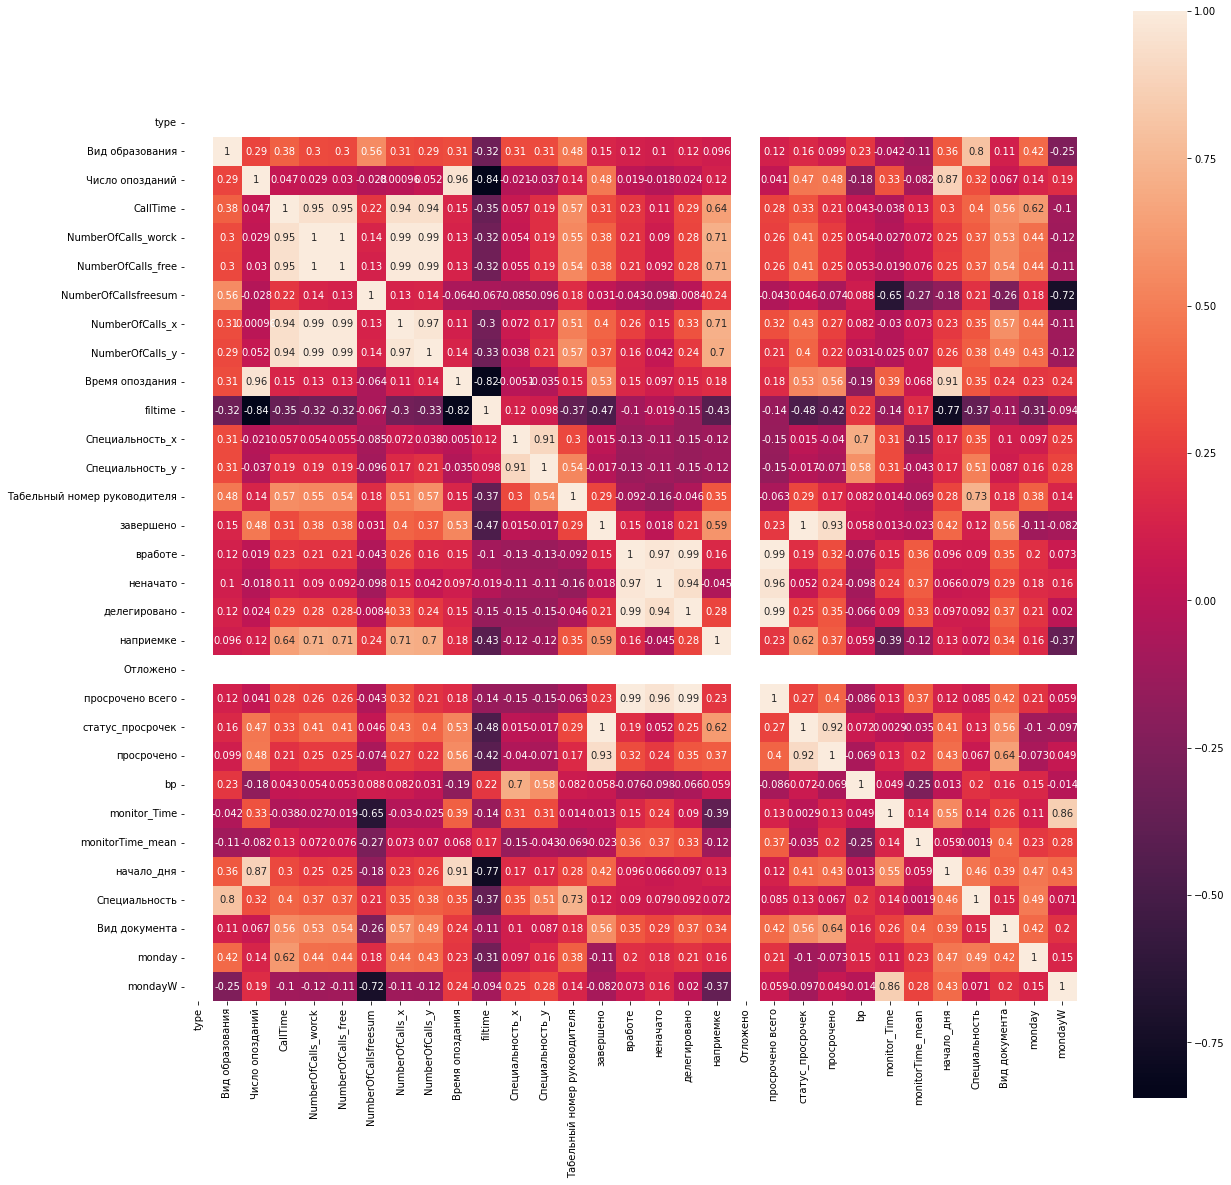

In [55]:
plt.rcParams['figure.figsize']=(20,20)

corr = df_train.query('type==3').corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

In [56]:
X = df_train.drop(['id', 'type',], axis = 1)
y = df_train["type"].map({0:0,1:0,2:1,3:0,})

# Стандартизация величин!

In [57]:
scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)

array([[ 0.73843104, -0.63704669, -0.26130887, ..., -0.88173867,
         0.74667738,  0.56473021],
       [-0.44650572, -0.6014954 ,  0.54960802, ...,  0.36253655,
         0.74667738,  0.56473021],
       [-0.44650572, -0.33486077, -0.70999231, ..., -1.19280748,
        -1.07772315, -2.28856548],
       ...,
       [-0.74273991, -0.7259249 , -0.70999231, ..., -1.19280748,
        -1.07772315, -0.25049713],
       [-0.74273991, -0.51261719,  0.92183569, ...,  0.36253655,
         1.11155749,  0.56473021],
       [-0.74273991, -0.7259249 , -0.6979493 , ...,  2.2289494 ,
        -0.71284305, -2.28856548]])

In [58]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Вид образования               550 non-null    int8   
 1   Число опозданий               550 non-null    float64
 2   CallTime                      550 non-null    float64
 3   NumberOfCalls_worck           550 non-null    float64
 4   NumberOfCalls_free            550 non-null    float64
 5   NumberOfCallsfreesum          550 non-null    float64
 6   NumberOfCalls_x               550 non-null    float64
 7   NumberOfCalls_y               550 non-null    float64
 8   Время опоздания               550 non-null    float64
 9   filtime                       550 non-null    float64
 10  Специальность_x               550 non-null    float64
 11  Специальность_y               550 non-null    float64
 12  Табельный номер руководителя  550 non-null    float64
 13  завер

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели

In [60]:
clf=GradientBoostingClassifier(max_depth=1)

# Выбор фич для обучения

In [61]:
selector = RFE(clf, n_features_to_select=30, step=1)
selector = selector.fit(X_train, y_train)
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [62]:
pd.DataFrame(selector.support_,index=X.columns,columns=['Rank'])

,Rank
Вид образования,True
Число опозданий,True
CallTime,True
NumberOfCalls_worck,True
NumberOfCalls_free,True
NumberOfCallsfreesum,True
NumberOfCalls_x,True
NumberOfCalls_y,True
Время опоздания,True
filtime,True


In [63]:
X_train=selector.transform(X_train)

In [64]:
X_train

array([[ 6.00000000e+00,  8.00000000e+00,  1.92109611e+19, ...,
         5.00000000e+00,  1.20000000e+01,  7.00000000e+00],
       [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  7.00000000e+00],
       [ 0.00000000e+00,  4.40000000e+01,  1.04104972e+19, ...,
         6.00000000e+00,  1.00000000e+01,  7.00000000e+00],
       ...,
       [-1.00000000e+00,  0.00000000e+00,  4.01666667e+17, ...,
         0.00000000e+00,  2.00000000e+00,  7.00000000e+00],
       [ 0.00000000e+00,  1.14000000e+02,  1.38096169e+19, ...,
         1.00000000e+01,  1.20000000e+01,  7.00000000e+00],
       [ 0.00000000e+00,  2.36000000e+02,  1.94276414e+19, ...,
         8.00000000e+00,  1.20000000e+01,  7.00000000e+00]])

parametrs = { 'max_depth':range(1,10),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,1) }
grid = GridSearchCV(clf, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

for i in range(1,200):
    clf=RandomForestClassifier(max_depth= 7, min_samples_leaf= 2, min_samples_split= 5,n_estimators=i)
    clf.fit(X_train, y_train)
    pred = clf.predict(selector.transform(X_test))
    print(i,"Recall score:", recall_score(y_test, pred, average='macro'))

In [65]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=1)

## Оценка точности

In [66]:
pred = clf.predict(X_test)

/home/gennadii/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [67]:
y_test.head(3)

195    1
79     1
480    0
Name: type, dtype: int64

In [68]:

print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.6016666666666667


In [69]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.58      0.52      0.55        50
           1       0.63      0.68      0.66        60

    accuracy                           0.61       110
   macro avg       0.60      0.60      0.60       110
weighted avg       0.61      0.61      0.61       110



## Генерация предсказания

In [70]:
df_test

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0
...,...,...
257,ОРГ1-02893,0
258,ОРГ2-01077,0
259,ОРГ1-00469,0
260,ОРГ1-02060,0


## Добавим фичи.

In [71]:
df_test = pd.merge(df_test, df_ed , on="id", how='left').drop_duplicates(subset="id")
df_test = df_test.drop(["Табельный номер руководителя", "Специальность"],axis = 1)
df_test["Вид образования"] = df_test["Вид образования"].astype('category')
df_test["Вид образования"] = df_test["Вид образования"].cat.codes
df_test = pd.merge(df_test, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

# Добавим суммарное время звоков

In [72]:
df_test = pd.merge(df_test, CallTime , on="id", how='left')

## Добавим колличество звонков в будни и выходные дни

In [73]:
df_test = pd.merge(df_test, NumberOfCalls , on="id", how='left')
df_test = pd.merge(df_test, NumberOfCallsW , on="id", how='left')
df_test = pd.merge(df_test, NumberOfCallsNW , on="id", how='left')
df_test = df_test.rename(columns={'NumberOfCalls_x': 'NumberOfCalls_worck','NumberOfCalls_y': 'NumberOfCalls_free','NumberOfCalls': 'NumberOfCallsfreesum'})

## Добавим колличество входящих и исходящих

In [74]:
df_test = pd.merge(df_test, NumberToUser , on="id", how='left')
df_test = pd.merge(df_test, NumberFromUser , on="id", how='left')

# Добавим суммарное время опоздания

In [75]:
df_test = pd.merge(df_test, falout , on="id", how='left')

# Добавим дельту прихода на работу

In [76]:
df_test  = pd.merge(df_test, filtime , on="id", how='left')

# Добавим профессию

In [77]:
profession=df_ed[['id','Специальность']].groupby('id')['Специальность'].min()
df_test = pd.merge(df_test, professionstart , on="id", how='left')
df_test = pd.merge(df_test, professionend , on="id", how='left')

In [78]:
df_test.head()

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,Время опоздания,filtime,Специальность_x,Специальность_y
0,ОРГ1-02649,0,-1,NaN,1.045278e+17,4.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,ОРГ2-05929,0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN,9.550722e+17,-1057.019584,999.0,999.0
2,ОРГ2-05859,0,8,104.0,NaN,NaN,NaN,NaN,NaN,NaN,5.190126e+18,-2103.577020,NaN,NaN
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,5.900416e+17,-570.718116,4.0,4.0
4,ОРГ2-01613,0,2,17.0,NaN,NaN,NaN,NaN,NaN,NaN,1.839148e+18,-386.013125,4.0,4.0


## Добавим колличество руководителей

In [79]:
df_test = pd.merge(df_test, boss , on="id", how='left')

# Добавим колличество завершенных заданий.

In [80]:
df_test = pd.merge(df_test,status_mission_count, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_in, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_nn, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_d, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_p, on="id", how='left')
df_test = pd.merge(df_test,status_mission_count_o, on="id", how='left')

# Добавим сумму просроченных дней

In [81]:
df_test = pd.merge(df_test,day_ful_mission, on="id", how='left')

# Добавим статус по просрочке с нарушением без науршения и их отношение.

In [82]:
df_test = pd.merge(df_test,fail_count_b, on="id", how='left')
df_test = pd.merge(df_test,fail_count_p, on="id", how='left')
df_test['bp']=df_test['статус_просрочек']/df_test['просрочено']

# Добавим общее время активности в сети.

In [83]:
df_test = pd.merge(df_test,timennetwork_time, on="id", how='left')

# Добавим среднее время простоя монитора 

In [84]:
df_test = pd.merge(df_test,monitor_stop, on="id", how='left')

# Добавим счетчик начала рабочего дня

In [85]:
df_test = pd.merge(df_test,start_day, on="id", how='left')

## Добавим колличество уникальных специальностей

In [86]:
df_test = pd.merge(df_test,prof_countis, on="id", how='left')

# Добавим оборотные виды документов

In [87]:
df_test = pd.merge(df_test,documents, on="id", how='left')

# Добавим месяцы звонков

In [88]:
df_test = pd.merge(df_test,monday_calls, on="id", how='left')

# Добавим месяцы в сети

In [89]:
df_test = pd.merge(df_test,monday_worck, on="id", how='left')

# Удалим пустые значения

In [90]:
df_test = df_test.fillna(0)

In [91]:
df_test

,id,type,Вид образования,Число опозданий,CallTime,NumberOfCalls_worck,NumberOfCalls_free,NumberOfCallsfreesum,NumberOfCalls_x,NumberOfCalls_y,...,статус_просрочек,просрочено,bp,monitor_Time,monitorTime_mean,начало_дня,Специальность,Вид документа,monday,mondayW
0,ОРГ1-02649,0,-1,0.0,1.045278e+17,4.0,4.0,0.0,0.0,4.0,...,0.0,0.0,0.000000,1216102.0,8473.741758,0.0,0.0,0.0,2.0,4.0
1,ОРГ2-05929,0,1,19.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,1460567.0,1619.017143,101.0,1.0,0.0,0.0,7.0
2,ОРГ2-05859,0,8,104.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.0,19.0,0.052632,3838028.0,872.878345,249.0,0.0,2.0,0.0,7.0
3,ОРГ1-00279,0,0,15.0,3.790214e+19,8163.0,8134.0,29.0,3679.0,4484.0,...,490.0,27.0,18.148148,3738371.0,2799.358247,138.0,1.0,7.0,12.0,7.0
4,ОРГ2-01613,0,2,17.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,6.0,3.0,2.000000,2078269.0,4975.621779,136.0,1.0,3.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,ОРГ1-02893,0,9,117.0,1.244414e+19,1404.0,1357.0,47.0,875.0,529.0,...,4.0,0.0,0.000000,2412880.0,605.111872,244.0,1.0,2.0,12.0,5.0
258,ОРГ2-01077,0,2,29.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,0.333333,2662108.0,8434.996021,183.0,1.0,2.0,0.0,7.0
259,ОРГ1-00469,0,0,2.0,2.311854e+19,5103.0,5103.0,0.0,2646.0,2457.0,...,154.0,84.0,1.833333,3642242.0,6811.915060,116.0,1.0,5.0,12.0,7.0
260,ОРГ1-02060,0,0,1.0,1.104076e+19,1251.0,1248.0,3.0,528.0,723.0,...,45.0,4.0,11.250000,80446.0,1551.701493,9.0,1.0,5.0,12.0,1.0


## Предсказания

In [92]:
df_test_pred = pd.read_csv("test.csv")
Xpred = df_test.drop(['id', 'type'], axis = 1)
scaler.transform(Xpred)
Xpred=selector.transform(Xpred)
preds = clf.predict(Xpred)
df_test_pred['type']=preds

In [93]:
df_test_pred.to_csv('GradientBoostingClassifier.csv', index=False)

In [94]:
df_test_pred['type'].value_counts()

1    175
0     87
Name: type, dtype: int64